# Mark and Recapture 

We take the earlier developed model of "Commited moose" (the ones that move in a straight line, and get reflected by enclosure borders). But also even before starting the movement, we mark all animals in one corner. It's like as if we captured them, marked them, and released them.

And then at some point in time we trap them again (look at all animals in this corner), count how many of them are marked (how many of them were captured before), and use this info to estimate the number of animals in the system.

(Here we of course have the God-like knowledge of the true number of animals in the system, so what we are trying to check is whether an estimation an ecologist would have made would have been reasonable.)

We'll use the following formula for the estimation (taken from Wikipedia): ${\displaystyle {\hat {N}}_{C}={\frac {(K+1)(n+1)}{k+1}}-1}$

And then, in practice, we'll make our 'fake ecologist' estimate the number of animals in the system at every step of the loop. Not because they would do so in practice (in practice they would have waited for some time of course, and then they would have re-traped the animals once or twice), but just because we can do it. And it can lead to useful predictions, like, when should an ecologist retrap the animals? How long should they wait?

Changes vs previous version:
* All constants moved from global variables to a class, as class properties
* The model is made into a function
* The "running dotses" visualization is made conditional (so we haven't deleted it completely), but it is now inactivated by default

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
#Define constants, but we do it as a class (to later make passing it around easier)

class Const:
    def __init__(self):
        self.n_animals = 100
        self.n_steps = 200
        self.vmin = 0.01
        self.vmax = 0.05
        self.trap_size = 0.4 # All critters with x<this and y<this will be considred "captured"
        self.trap_location = 'corner' # Two options: 'corner' or 'center'
        self.death_rate = 0.01 # Probability of an animal being replaced at every time step

In [4]:
#Build the model
def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        x = np.random.uniform(size=c.n_animals)
        y = np.random.uniform(size=c.n_animals)
        vx = np.random.uniform(size=c.n_animals, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals,low=0,high=2) - 1)

        # First capture
        if c.trap_location=='corner':
            color = np.where(np.logical_and(x<c.trap_size , y<c.trap_size), 1, 0)
        else:
            color = np.where((x<0.5+c.trap_size/2)*(x>0.5-c.trap_size/2)*(
                y<0.5+c.trap_size/2)*(y>0.5-c.trap_size/2), 1, 0)
        # All animals are color 0 by default, but are colored 1 when they are captured
        n_marked = np.sum(color)

        estimation = np.zeros(c.n_steps)  # Main output variable. At every point in time
                                        # .. we'll remember the estimation for N an ecologist could have made 

        if show_dotses: # Plotting
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots actually, just creating axes
            plt.xlim((0,1));
            plt.ylim((0,1));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            # Moving elks around
            x += vx
            y += vy

            # Reflect from the walls
            vx = np.where(np.logical_or(x>1,x<0), -vx , vx)
            vy = np.where(np.logical_or(y>1,y<0), -vy , vy)
            
            is_replaced = np.random.uniform(size=c.n_animals)<c.death_rate
            color[is_replaced] = 0 # These lose color

            # Recapture
            if c.trap_location=='corner':
                is_inside = (x<c.trap_size)*(y<c.trap_size)
            else:
                is_inside = (x<0.5+c.trap_size/2)*(x>0.5-c.trap_size/2)*(y<0.5+c.trap_size/2)*(y>0.5-c.trap_size/2)
            n_recaptured_total = np.sum(is_inside)
            n_recaptured_marked = np.sum(is_inside*color) 
            estimation[t] = (n_marked+1)/(n_recaptured_marked+1)*(n_recaptured_total)-1 # Chapman estimator

            if show_dotses: # Actual animation
                ax.clear()
                plt.plot(x[color==0], y[color==0], 'k.',markersize=5);
                plt.plot(x[color==1], y[color==1], 'r.',markersize=5)
                plt.xlim((0,1));
                plt.ylim((0,1));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)

        history[:,i_trial] = estimation
    return np.mean(history, axis=1)

<IPython.core.display.Javascript object>


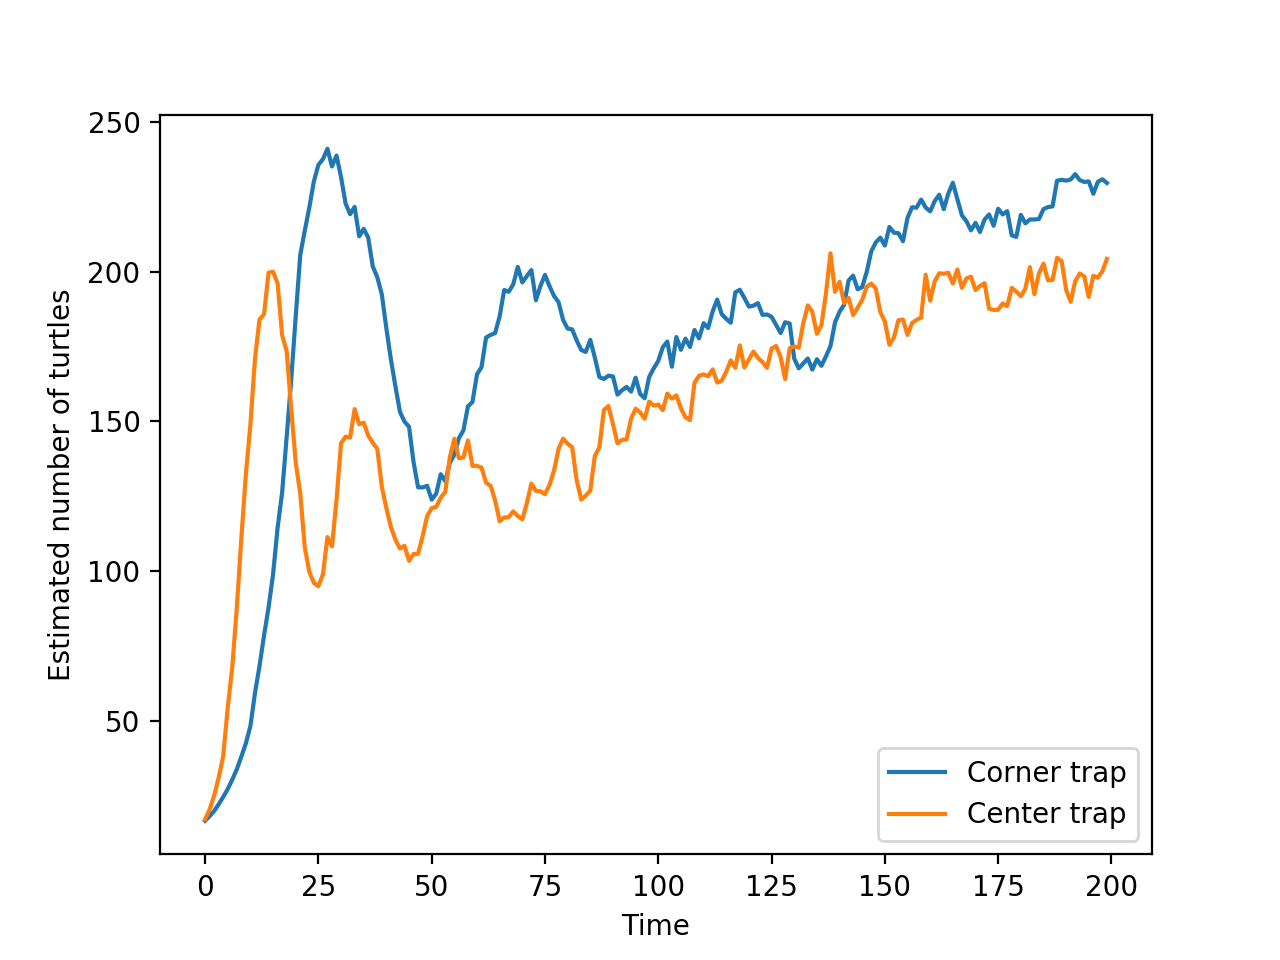

In [5]:
#Main program

c = Const()
curve1 = model(c, n_trials=100)
c.trap_location = 'center'
curve2 = model(c, n_trials=100)

plt.figure()
plt.plot(curve1, label='Corner trap');
plt.plot(curve2, label='Center trap');
plt.xlabel('Time');
plt.ylabel('Estimated number of turtles');
plt.legend(loc='lower right');